In [ ]:
import os
import random
import glob
import itertools
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


VOCAB_SIZE = 20000
MAX_LEN = 128  
EMBED_DIM = 128
LSTM_UNITS = 128
DROPOUT = 0.3


TensorFlow version: 2.16.2


In [ ]:

import glob
import os
import pandas as pd

DATA_DIR = "archive"  


def load_clause_dataset(data_dir):
    files = sorted(glob.glob(os.path.join(data_dir, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")

    frames = []
    for f in files:
        print("Reading:", os.path.basename(f))
        df = pd.read_csv(f)

        # ✅ ensure correct columns exist
        if "clause_text" not in df.columns or "clause_type" not in df.columns:
            raise ValueError(f"CSV {f} must contain clause_text and clause_type")

        df["clause_text"] = df["clause_text"].astype(str).str.strip()
        df["clause_type"] = df["clause_type"].astype(str).str.strip()
        frames.append(df)

    full = pd.concat(frames, ignore_index=True)
    return full


df = load_clause_dataset(DATA_DIR)
print("Loaded clauses:", len(df))
print("Unique clause types:", df["clause_type"].nunique())
df.head()

Reading: absence-of-certain-changes-or-events.csv
Reading: absence-of-certain-changes.csv
Reading: acceleration.csv
Reading: access-to-information.csv
Reading: access.csv
Reading: accounting-terms.csv
Reading: additional-agreements.csv
Reading: additional-documents.csv
Reading: adjustments.csv
Reading: affirmative-covenants.csv
Reading: agreement.csv
Reading: agreements.csv
Reading: amendment-and-waiver.csv
Reading: amendment-waiver.csv
Reading: amendment.csv
Reading: amendments-and-waivers.csv
Reading: amendments-etc.csv
Reading: amendments-waivers.csv
Reading: amendments.csv
Reading: applicable-law.csv
Reading: application-of-proceeds.csv
Reading: appointment.csv
Reading: approvals.csv
Reading: arbitration.csv
Reading: assignability.csv
Reading: assignment.csv
Reading: assignments.csv
Reading: attorneys-fees.csv
Reading: authority.csv
Reading: authorization.csv
Reading: auto_renewal.csv
Reading: background.csv
Reading: bank-accounts.csv
Reading: bankruptcy.csv
Reading: base-salary.cs

,clause_text,clause_type
0,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events
1,Absence of Certain Changes or Events. Since Ma...,absence-of-certain-changes-or-events
2,Absence of Certain Changes or Events. (a) Sinc...,absence-of-certain-changes-or-events
3,Absence of Certain Changes or Events. Since th...,absence-of-certain-changes-or-events
4,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events


In [ ]:
def create_pairs(df, max_pos_pairs_per_type=2000, neg_pos_ratio=1.0):
    # group by clause_type
    groups = {k: list(v) for k, v in df.groupby("clause_type").indices.items()}

    pos_pairs = []
    for clause_type, idxs in groups.items():
        if len(idxs) < 2:
            continue  # can't make pairs

        # all combinations inside the same type
        all_comb = list(itertools.combinations(idxs, 2))
        random.shuffle(all_comb)

        selected = all_comb[:max_pos_pairs_per_type]
        for i, j in selected:
            pos_pairs.append((df.loc[i, "clause_text"], df.loc[j, "clause_text"], 1))

    # Negative pairs
    neg_pairs = []
    all_types = list(groups.keys())
    needed_neg = int(len(pos_pairs) * neg_pos_ratio)

    # create neg pairs safely
    while len(neg_pairs) < needed_neg:
        t1, t2 = random.sample(all_types, 2)

        if len(groups[t1]) == 0 or len(groups[t2]) == 0:
            continue

        i = random.choice(groups[t1])  # now groups[...] is a list ✅
        j = random.choice(groups[t2])
        neg_pairs.append((df.loc[i, "clause_text"], df.loc[j, "clause_text"], 0))

    # final df
    pairs = pos_pairs + neg_pairs
    random.shuffle(pairs)
    pairs_df = pd.DataFrame(pairs, columns=["text_a", "text_b", "label"])
    return pairs_df


pairs_df = create_pairs(df, max_pos_pairs_per_type=300, neg_pos_ratio=1.0)
print("Pairs created:", len(pairs_df))
pairs_df["label"].value_counts()
pairs_df.sample(5)

Pairs created: 236610


,text_a,text_b,label
8546,Legal Proceedings. Other than as set forth in ...,Legal Proceedings. Except as set forth on Sect...,1
5601,"Guarantee. Parent shall, and hereby does, cont...",Brokers. The Company will not be responsible f...,0
7117,"Miscellaneous. The reimbursement, indemnificat...",Miscellaneous. 12.1 No Option will confer upon...,1
203051,NEGATIVE COVENANTS. So long as any Notes are O...,Security Interest. Nothing in this Agreement s...,0
194126,Liability. TAEC WILL UNDER NO CIRCUMSTANCES BE...,Non-Competition. In consideration of the benef...,0


In [ ]:
TEST_SIZE = 0.10
VAL_SIZE = 0.10  # of train 

train_val, test_df = train_test_split(
    pairs_df, test_size=TEST_SIZE, stratify=pairs_df["label"], random_state=SEED
)
train_df, val_df = train_test_split(
    train_val, test_size=VAL_SIZE, stratify=train_val["label"], random_state=SEED
)

print("Train / Val / Test sizes:", len(train_df), len(val_df), len(test_df))

all_texts = pd.concat(
    [
        train_df["text_a"],
        train_df["text_b"],
        val_df["text_a"],
        val_df["text_b"],
        test_df["text_a"],
        test_df["text_b"],
    ]
)
VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(all_texts.tolist())

MAX_LEN = 128  # can adjust


def texts_to_padded_sequences(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")


# Convert to numpy arrays for model input
def df_to_inputs(df):
    a = texts_to_padded_sequences(df["text_a"].tolist())
    b = texts_to_padded_sequences(df["text_b"].tolist())
    y = df["label"].astype(int).values
    return a, b, y


X1_train, X2_train, y_train = df_to_inputs(train_df)
X1_val, X2_val, y_val = df_to_inputs(val_df)
X1_test, X2_test, y_test = df_to_inputs(test_df)

print("Shapes:", X1_train.shape, X2_train.shape, y_train.shape)

Train / Val / Test sizes: 191654 21295 23661
Shapes: (191654, 128) (191654, 128) (191654,)


In [ ]:
def evaluate_and_print(model, X1, X2, y_true, batch_size=128):
    y_prob = model.predict([X1, X2], batch_size=batch_size).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        roc = roc_auc_score(y_true, y_prob)
    except:
        roc = float("nan")
    print(
        f"Acc: {acc:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {roc:.4f}"
    )
    print(
        "\nClassification report:\n",
        classification_report(y_true, y_pred, zero_division=0),
    )
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "roc": roc}


def plot_history(hist, title="Training"):
    plt.figure(figsize=(12, 4))
    # loss
    plt.subplot(1, 2, 1)
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title(title + " - Loss")
    plt.legend()
    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(
        hist.history.get("binary_accuracy", hist.history.get("accuracy")),
        label="train_acc",
    )
    plt.plot(
        hist.history.get("val_binary_accuracy", hist.history.get("val_accuracy")),
        label="val_acc",
    )
    plt.title(title + " - Accuracy")
    plt.legend()
    plt.show()

In [ ]:
#LSTM Model parameters
EMBED_DIM = 128
LSTM_UNITS = 128
DROPOUT = 0.3


def build_siamese_bilstm(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    max_len=MAX_LEN,
    lstm_units=LSTM_UNITS,
    dropout=DROPOUT,
):
    # shared embedding + encoder
    input_a = layers.Input(shape=(max_len,), name="input_a")
    input_b = layers.Input(shape=(max_len,), name="input_b")
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        input_length=max_len,
        mask_zero=True,
        name="embedding",
    )
    # encoder
    lstm = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=False), name="bilstm"
    )
    drop = layers.Dropout(dropout)
    # encode both
    encoded_a = drop(lstm(embedding(input_a)))
    encoded_b = drop(lstm(embedding(input_b)))
    # combine features
    abs_diff = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))(
        [encoded_a, encoded_b]
    )
    mult = layers.Multiply()([encoded_a, encoded_b])
    merged = layers.Concatenate()([encoded_a, encoded_b, abs_diff, mult])
    x = layers.Dense(256, activation="relu")(merged)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model([input_a, input_b], out, name="siamese_bilstm")
    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"]
    )
    return model


siamese_model = build_siamese_bilstm()
siamese_model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "siamese_bilstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │  2,560,000 │ input_a[0][0],    │
│ (Embedding)         │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 128)       │          0 │ input_a[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 128)       │          0 │ input_b[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 256)       │    263,168 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0… │
│                     │                   │            │ embedding[1][0],  │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ bilstm[0][0],     │
│                     │                   │            │ bilstm[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 256)       │          0 │ dropout_9[0][0],  │
│                     │                   │            │ dropout_9[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 256)       │          0 │ dropout_9[0][0],  │
│ (Multiply)          │                   │            │ dropout_9[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 1024)      │          0 │ dropout_9[0][0],  │
│ (Concatenate)       │                   │            │ dropout_9[1][0],  │
│                     │                   │            │ lambda_8[0][0],   │
│                     │                   │            │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 256)       │    262,400 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │     16,448 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1)         │         65 │ dense_26[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,102,081 (11.83 MB)

 Trainable params: 3,102,081 (11.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - binary_accuracy: 0.5215 - loss: 0.8175

2995/2995 ━━━━━━━━━━━━━━━━━━━━ 481s 160ms/step - binary_accuracy: 0.5529 - loss: 0.8752 - val_binary_accuracy: 0.5348 - val_loss: 1.8471
Epoch 2/5
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 504s 168ms/step - binary_accuracy: 0.5093 - loss: 3.3328 - val_binary_accuracy: 0.5314 - val_loss: 6.9274
Epoch 3/5
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 490s 164ms/step - binary_accuracy: 0.5276 - loss: 19.2171 - val_binary_accuracy: 0.5360 - val_loss: 67.6728
Epoch 4/5
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 491s 164ms/step - binary_accuracy: 0.5274 - loss: 251.7175 - val_binary_accuracy: 0.5763 - val_loss: 292.1404


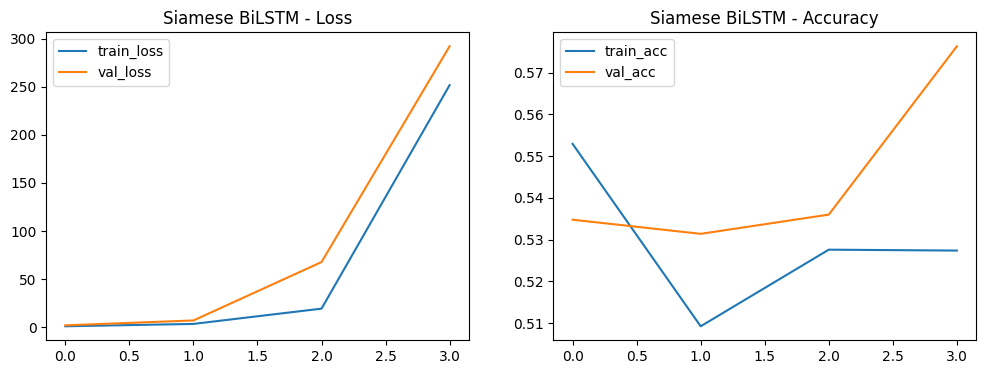

In [ ]:
#Training the  BiLSTM model
BATCH_SIZE = 64
EPOCHS = 5

checkpoint_path = "siamese_best.h5"
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss"),
]

hist_siam = siamese_model.fit(
    [X1_train, X2_train],
    y_train,
    validation_data=([X1_val, X2_val], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

plot_history(hist_siam, title="Siamese BiLSTM")

In [ ]:
print("Validation performance:")
evaluate_and_print(siamese_model, X1_val, X2_val, y_val)
print("\nTest performance:")
siam_metrics = evaluate_and_print(siamese_model, X1_test, X2_test, y_test)

Validation performance:
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step
Acc: 0.5348  Prec: 0.5282  Rec: 0.6508  F1: 0.5832  ROC-AUC: 0.5652

Classification report:
               precision    recall  f1-score   support

           0       0.55      0.42      0.47     10647
           1       0.53      0.65      0.58     10648

    accuracy                           0.53     21295
   macro avg       0.54      0.53      0.53     21295
weighted avg       0.54      0.53      0.53     21295


Test performance:
185/185 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step
Acc: 0.5299  Prec: 0.5240  Rec: 0.6518  F1: 0.5810  ROC-AUC: 0.5599

Classification report:
               precision    recall  f1-score   support

           0       0.54      0.41      0.46     11831
           1       0.52      0.65      0.58     11830

    accuracy                           0.53     23661
   macro avg       0.53      0.53      0.52     23661
weighted avg       0.53      0.53      0.52     23661



In [ ]:
# Attention layer
from tensorflow.keras.layers import Layer


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        # inputs shape: (batch, timesteps, features)
        scores = K.squeeze(K.tanh(K.dot(inputs, self.W)), axis=-1)  # (batch, timesteps)
        if mask is not None:
            mask = K.cast(mask, K.dtype(scores))
            scores -= (1.0 - mask) * 1e9
        alphas = K.softmax(scores)
        alphas = K.expand_dims(alphas, axis=-1)
        output = K.sum(inputs * alphas, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

In [ ]:
def build_attention_encoder(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    max_len=MAX_LEN,
    lstm_units=LSTM_UNITS,
    dropout=DROPOUT,
):
    input_a = layers.Input(shape=(max_len,), name="input_a")
    input_b = layers.Input(shape=(max_len,), name="input_b")
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        input_length=max_len,
        mask_zero=True,
        name="embedding",
    )
    bilstm = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))
    att = AttentionLayer()
    drop = layers.Dropout(dropout)

    enc_a = drop(att(bilstm(embedding(input_a))))
    enc_b = drop(att(bilstm(embedding(input_b))))
    abs_diff = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))(
        [enc_a, enc_b]
    )
    mult = layers.Multiply()([enc_a, enc_b])
    merged = layers.Concatenate()([enc_a, enc_b, abs_diff, mult])
    x = layers.Dense(256, activation="relu")(merged)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model([input_a, input_b], out, name="attention_encoder")
    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"]
    )
    return model


att_model = build_attention_encoder()
att_model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "attention_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │  2,560,000 │ input_a[0][0],    │
│ (Embedding)         │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 128)       │          0 │ input_a[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 128)       │          0 │ input_b[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 128, 256)  │    263,168 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_6[0][0… │
│                     │                   │            │ embedding[1][0],  │
│                     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 256)       │        256 │ bidirectional_16… │
│ (AttentionLayer)    │                   │            │ not_equal_6[0][0… │
│                     │                   │            │ bidirectional_16… │
│                     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ attention_layer[… │
│ (Dropout)           │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 256)       │          0 │ dropout_11[0][0], │
│                     │                   │            │ dropout_11[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 256)       │          0 │ dropout_11[0][0], │
│ (Multiply)          │                   │            │ dropout_11[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 1024)      │          0 │ dropout_11[0][0], │
│ (Concatenate)       │                   │            │ dropout_11[1][0], │
│                     │                   │            │ lambda_9[0][0],   │
│                     │                   │            │ multiply_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │    262,400 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │     16,448 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1)         │         65 │ dense_29[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,102,337 (11.83 MB)

 Trainable params: 3,102,337 (11.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - binary_accuracy: 0.6917 - loss: 1.3207

2995/2995 ━━━━━━━━━━━━━━━━━━━━ 669s 223ms/step - binary_accuracy: 0.7043 - loss: 2.5514 - val_binary_accuracy: 0.7373 - val_loss: 19.7402
Epoch 2/5
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - binary_accuracy: 0.7309 - loss: 7.6057

2995/2995 ━━━━━━━━━━━━━━━━━━━━ 660s 220ms/step - binary_accuracy: 0.7323 - loss: 9.3612 - val_binary_accuracy: 0.8026 - val_loss: 12.4130
Epoch 3/5
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 686s 229ms/step - binary_accuracy: 0.7468 - loss: 15.9588 - val_binary_accuracy: 0.8267 - val_loss: 13.8433
Epoch 4/5
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 682s 228ms/step - binary_accuracy: 0.7553 - loss: 23.9662 - val_binary_accuracy: 0.8112 - val_loss: 36.9650
Epoch 5/5
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 693s 231ms/step - binary_accuracy: 0.7629 - loss: 34.4712 - val_binary_accuracy: 0.7441 - val_loss: 44.6194


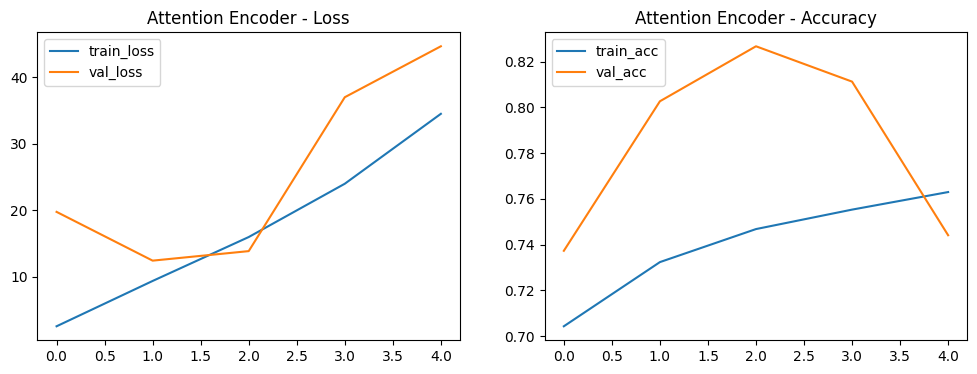

In [ ]:
checkpoint_path2 = "attention_best.h5"
callbacks2 = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    ModelCheckpoint(checkpoint_path2, save_best_only=True, monitor="val_loss"),
]

hist_att = att_model.fit(
    [X1_train, X2_train],
    y_train,
    validation_data=([X1_val, X2_val], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks2,
    verbose=1,
)

plot_history(hist_att, title="Attention Encoder")

In [ ]:
print("Attention Model - Validation performance:")
evaluate_and_print(att_model, X1_val, X2_val, y_val)
print("\nAttention Model - Test performance:")
att_metrics = evaluate_and_print(att_model, X1_test, X2_test, y_test)

# Quick comparison table
comparison = pd.DataFrame(
    {
        "model": ["Siamese_BiLSTM", "Attention_Encoder"],
        "test_acc": [siam_metrics["acc"], att_metrics["acc"]],
        "test_prec": [siam_metrics["prec"], att_metrics["prec"]],
        "test_rec": [siam_metrics["rec"], att_metrics["rec"]],
        "test_f1": [siam_metrics["f1"], att_metrics["f1"]],
        "test_roc": [siam_metrics["roc"], att_metrics["roc"]],
    }
)
display(comparison)

Attention Model - Validation performance:
167/167 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step
Acc: 0.8026  Prec: 0.7713  Rec: 0.8604  F1: 0.8134  ROC-AUC: 0.8505

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.79     10647
           1       0.77      0.86      0.81     10648

    accuracy                           0.80     21295
   macro avg       0.81      0.80      0.80     21295
weighted avg       0.81      0.80      0.80     21295


Attention Model - Test performance:
185/185 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step
Acc: 0.8074  Prec: 0.7766  Rec: 0.8630  F1: 0.8175  ROC-AUC: 0.8538

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80     11831
           1       0.78      0.86      0.82     11830

    accuracy                           0.81     23661
   macro avg       0.81      0.81      0.81     23661
weighted avg       0.81      0.81      0.81     

,model,test_acc,test_prec,test_rec,test_f1,test_roc
0,Siamese_BiLSTM,0.529902,0.524023,0.651817,0.580976,0.559873
1,Attention_Encoder,0.807405,0.776645,0.862975,0.817538,0.853836


In [ ]:
def qualitative_examples(model, X1, X2, y_true, df_pairs, n=10):
    y_prob = model.predict([X1, X2]).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    df_show = df_pairs.copy().reset_index(drop=True)
    df_show["prob"] = y_prob
    df_show["pred"] = y_pred
    df_show["true"] = y_true
    correct = df_show[df_show["pred"] == df_show["true"]].sample(min(n, len(df_show)))
    wrong = df_show[df_show["pred"] != df_show["true"]].sample(min(n, len(df_show)))
    print("Some correct predictions:")
    display(correct[["text_a", "text_b", "true", "pred", "prob"]].head(n))
    print("\nSome incorrect predictions:")
    display(wrong[["text_a", "text_b", "true", "pred", "prob"]].head(n))


qualitative_examples(siamese_model, X1_test, X2_test, y_test, test_df, n=5)

In [ ]:


def show_model_predictions(siam_model, att_model, X1, X2, df_pairs, n=10):
    # Make model predictions
    siam_prob = siam_model.predict([X1, X2]).ravel()
    att_prob = att_model.predict([X1, X2]).ravel()

    siam_pred = (siam_prob >= 0.5).astype(int)
    att_pred = (att_prob >= 0.5).astype(int)

    # Prepare dataframe
    temp = df_pairs.copy().reset_index(drop=True)
    temp["true_label"] = temp["label"]

    temp["siam_prob"] = siam_prob
    temp["siam_pred"] = siam_pred

    temp["att_prob"] = att_prob
    temp["att_pred"] = att_pred

    # Sample n rows
    sample = temp.sample(n)

    # Display only relevant columns
    display(
        sample[
            [
                "text_a",
                "text_b",
                "true_label",
                "siam_pred",
                "siam_prob",
                "att_pred",
                "att_prob",
            ]
        ]
    )


#  Show predictions for test set
show_model_predictions(
    siam_model=siamese_model,
    att_model=att_model,
    X1=X1_test,
    X2=X2_test,
    df_pairs=test_df,
    n=10,  # change number if you want more/less
)

740/740 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step


,text_a,text_b,true_label,siam_pred,siam_prob,att_pred,att_prob
18576,RECITALS. A. The Company is aware that because...,DURATION OF AGREEMENT. 29.01 This Agreement sh...,0,1,0.774064,1,1.000000
19222,Intellectual Property. Each of the Loan Partie...,Intellectual Property. Except as set forth in ...,1,1,1.000000,1,1.000000
814,R E C I T A L S. IB and the Borrower have requ...,"R E C I T A L S. The Depositor, the Property T...",1,0,0.067593,1,1.000000
17056,Marketing and Publicity. 8.1. The Company will...,Marketing and Publicity. 13.1 All publicity an...,1,1,0.773962,0,0.000023
13962,"Documents. As of the date hereof, except as se...",Sick Leave. (a) Full-time employees will conti...,0,1,0.778459,0,0.000000
23270,Adjustments. If at any time during the period ...,Adjustments. In the event of a breach of any o...,1,0,0.001587,1,0.999999
11333,Accounting Terms. For purposes of this Agreeme...,Name. The name of the Company is as set forth ...,0,1,0.778471,0,0.000000
17233,Governing Law. This Assignment Agreement shall...,Descriptive Headings. The descriptive headings...,0,1,0.778475,0,0.000000
16631,"Capitalization. The authorized, issued and out...",Compensation and Benefits. In consideration fo...,0,1,0.770926,0,0.000000
13549,Compliance with Laws. Borrower will comply wit...,"Approvals. No material order, consent, approva...",0,1,0.684466,1,1.000000
